<a href="https://colab.research.google.com/github/Reinaldo-Araujo/cat_X_dogs_DIO_Transfer/blob/main/DIO_Treinamento_RN_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Carrega Bibliotecas
import os
import shutil
import random
import numpy as np
import zipfile
import urllib.request
import cv2
from keras.applications import VGG16
from keras.layers import Dense, Flatten
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

In [99]:
# Carrrega VGG16 coo base
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


58889256/58889256 [==============================] - 1s 0us/step


In [100]:
# Congela as camadas
for layer in base_model.layers:
    layer.trainable = False

In [101]:
# Determina numero de classes
num_classes = 2

In [102]:
# Acresenta uma nova ultima camada (superior)
x = base_model.output
x = Flatten()(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [103]:
# Determina o modelo
model = Model(inputs=base_model.input, outputs=predictions)

In [104]:
# Compile o modelo
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
# Carrega Dataset da Microsoft
url = 'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip'
urllib.request.urlretrieve(url, 'dataset.zip')


('dataset.zip', <http.client.HTTPMessage at 0x7f514b09abe0>)

In [119]:
# Descompacta Dataset
with zipfile.ZipFile("dataset.zip","r") as zip_ref:
    zip_ref.extractall("/content/Dataset")


In [120]:
# Caminho do diretório com as imagens
path = '/content/Dataset/PetImages/'

# Reduz o Dataset em 10%
source_folder = '/content/Dataset/PetImages/Cat'
destination_folder = '/content/Dataset/PetImagesSmall/Cat'
os.makedirs(destination_folder)

files = os.listdir(source_folder)
files_to_move = random.sample(files, int(len(files) * 0.1))

for file_name in files_to_move:
    source_path = os.path.join(source_folder, file_name)
    destination_path = os.path.join(destination_folder, file_name)
    shutil.move(source_path, destination_path)

source_folder = '/content/Dataset/PetImages/Dog'
destination_folder = '/content/Dataset/PetImagesSmall/Dog'
os.makedirs(destination_folder)

files = os.listdir(source_folder)
files_to_move = random.sample(files, int(len(files) * 0.1))

for file_name in files_to_move:
    source_path = os.path.join(source_folder, file_name)
    destination_path = os.path.join(destination_folder, file_name)
    shutil.move(source_path, destination_path)


# Caminho do diretório com menos imagens
path = '/content/Dataset/PetImagesSmall/'

# Caminhos dos diretórios de treinamento e validação
train_dir = '/content/train/'
val_dir = '/content/val/'

# Apaga dados antigos se já existirem
if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
if os.path.exists(val_dir):
    shutil.rmtree(val_dir)

# Criando os diretórios de treinamento e validação 
os.makedirs(train_dir)
os.makedirs(val_dir)

# Percentual de imagens para validação
val_percent = 0.2

# Guardando as categorias
categories = os.listdir(path)

# Classificando os arquivos nas pastas para o modelo
for folder in os.listdir(path):
    folder_path = os.path.join(path, folder)
  
    files = os.listdir(folder_path)
    print('Pasta ',folder_path,' contem ',len([f for f in files if os.path.isfile(os.path.join(folder_path, f))]),' arquivos')

    if os.path.isdir(folder_path):
        # Movendo sobre as imagens da pasta
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            if os.path.isfile(file_path):
                # Criando as pastas de destino
                if not os.path.exists(val_dir+folder+'/'):
                    os.makedirs(val_dir+folder+'/')
                if not os.path.exists(train_dir+folder+'/'):
                    os.makedirs(train_dir+folder+'/')
                # Sorteando se a imagem vai para o conjunto de treinamento ou validação
                if np.random.rand() < val_percent:
                    # Move para o conjunto de validação
                    shutil.move(file_path, val_dir+folder+'/')
                else:
                    # Move para o conjunto de treinamento
                    shutil.move(file_path, train_dir+folder+'/')



Pasta  /content/Dataset/PetImagesSmall/Cat  contem  1250  arquivos
Pasta  /content/Dataset/PetImagesSmall/Dog  contem  1250  arquivos


In [149]:
# Prepara os Dados
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(directory='/content/train',
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(directory='/content/val',
                                                        target_size=(224, 224),
                                                        batch_size=32,
                                                        class_mode='categorical')

Found 1997 images belonging to 2 classes.
Found 503 images belonging to 2 classes.


In [123]:
num_epochs = 2


In [150]:
# Treina o modelo
model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=num_epochs,
                    validation_data=validation_generator,
                    validation_steps=len(validation_generator))

Epoch 1/2
63/63 [==============================] - 1353s 22s/step - loss: 0.2276 - accuracy: 0.9049 - val_loss: 0.1834 - val_accuracy: 0.9165
Epoch 2/2
63/63 [==============================] - 1353s 22s/step - loss: 0.1906 - accuracy: 0.9179 - val_loss: 0.2769 - val_accuracy: 0.9006


1/1 [==============================] - 1s 592ms/step


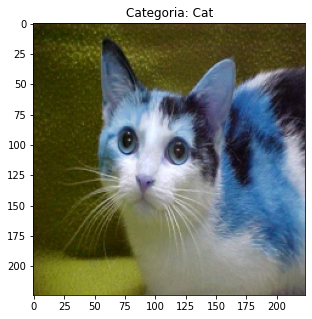

In [162]:
# Carrega a imagem aleatória de um gato
path = '/content/Dataset/PetImages/Cat'
files = [os.path.join(path, f) for f in os.listdir(path)]

# Escolha aleatoria de arquivo
file = random.choice(files)

# Carrega a imagem
img = cv2.imread(file)

# Pré-processamento da imagem
img = cv2.resize(img, (224, 224))
img = img.astype('float32') / 255

# Passando a imagem para o modelo
prediction = model.predict(np.expand_dims(img, axis=0))

# Obtendo a categoria com a maior probabilidade
category_index = np.argmax(prediction)

# Mapeando o valor numérico para o nome da categoria
category_name = categories[category_index]

# Mostrando o resultado
plt.figure(figsize=(5,5))
plt.imshow(img)
plt.title(f'Categoria: {category_name}')
plt.show()


1/1 [==============================] - 1s 615ms/step


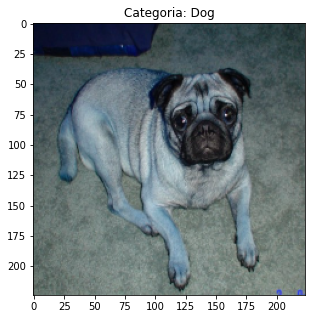

In [163]:
# Carrega a imagem aleatória de um cachorro
path = '/content/Dataset/PetImages/Dog'
files = [os.path.join(path, f) for f in os.listdir(path)]

# Escolha aleatoria de arquivo
file = random.choice(files)

# Carrega a imagem
img = cv2.imread(file)

# Pré-processamento da imagem (opcional)
img = cv2.resize(img, (224, 224))
img = img.astype('float32') / 255

# Passando a imagem para o modelo
prediction = model.predict(np.expand_dims(img, axis=0))

# Obtendo a categoria com a maior probabilidade
category_index = np.argmax(prediction)

# Mapeando o valor numérico para o nome da categoria
category_name = categories[category_index]

# Mostrando o resultado
plt.figure(figsize=(5,5))
plt.imshow(img)
plt.title(f'Categoria: {category_name}')
plt.show()


In [154]:
file

'/content/Dataset/PetImages/Dog/9138.jpg'